In [2]:
import numpy as np
import geopandas as gp
import pandas as pd
from rasterio.plot import show
import rasterio as rio
import rasterio.features
import rasterio.warp
import earthpy.spatial as es
import tarfile
import os
from shapely.geometry import Polygon
from matplotlib import pyplot
import matplotlib.pyplot as plt
import json
import pickle
import pyproj;                                 #pyproj.set_datapath("C:/Users/User/Anaconda3/envs/geo/Lib/site-packages/pyproj")
import landsatxplore.api
from landsatxplore.earthexplorer import EarthExplorer                                  # https://pypi.org/project/landsatxplore/
from collections.abc import Iterable
import time
import math
from ipypb import track
import seaborn as sn

os.chdir(r"C:\Users\User\Documents\Work\SDGs and AI\6.3.2")

### Read in list of sites for download

In [3]:
#sites = pickle.load(open("sites.p","rb"))
sites = pd.read_pickle("sites.p")

In [4]:
list(sites)

['wb_cat',
 'determinand_id',
 'value',
 'lon',
 'lat',
 'geometry',
 'checked',
 'l7_scene_n1d10c',
 'l8_scene_n1d10c',
 'l7_scene_id',
 'l7_scene_dt',
 'l8_scene_id',
 'l8_scene_dt',
 'l7_scene_n4d20c',
 'l8_scene_n4d20c']

In [ ]:
sites[sites.l8 'LC08_L1TP_207024_20170503_20170515_01_T1']

In [615]:
sc_meta

[{'acquisitionDate': '2017-05-03',
  'startTime': '2017-05-03',
  'endTime': '2017-05-03',
  'spatialFootprint': {'type': 'Polygon',
   'coordinates': [[[-10.46011, 51.06625],
     [-7.8373, 50.60437],
     [-7.02474, 52.29471],
     [-9.74403, 52.76481],
     [-10.46011, 51.06625]]]},
  'sceneBounds': '-10.46011,50.60437,-7.02474,52.76481',
  'browseUrl': 'https://ims.cr.usgs.gov/browse/landsat_8_c1/2017/207/024/LC08_L1TP_207024_20170503_20170515_01_T1.jpg',
  'dataAccessUrl': 'https://earthexplorer.usgs.gov/order/process?dataset_name=LANDSAT_8_C1&ordered=LC82070242017123LGN00&node=INVSVC',
  'downloadUrl': 'https://earthexplorer.usgs.gov/download/external/options/LANDSAT_8_C1/LC82070242017123LGN00/INVSVC/',
  'entityId': 'LC82070242017123LGN00',
  'displayId': 'LC08_L1TP_207024_20170503_20170515_01_T1',
  'cloudCover': 7.52,
  'metadataUrl': 'https://earthexplorer.usgs.gov/metadata/xml/12864/LC82070242017123LGN00/',
  'fgdcMetadataUrl': 'https://earthexplorer.usgs.gov/fgdc/12864/LC82

In [2]:
### dummy site

scid = 'LC82070242017123LGN00'

### Open scene metadata and add to site list

https://lta.cr.usgs.gov/DD/landsat_dictionary.html#landsat_product_id

In [3]:
sc_meta = pickle.load(open('./Landsat/Scenes/scene_'+str(scid)+".p","rb"))

In [2]:
polygon = gp.read_file("./Shapefiles/doksa.shp")

In [607]:
polygon = polygon.to_crs(dll.crs)

In [608]:
m = Map(center=(51.93472,-9.77300), zoom = 12, basemap= basemaps.Esri.WorldTopoMap)

lakes_plot = GeoData(geo_dataframe = polygon,
                   style={'color': 'black', 'fillColor': '#3366cc', 'opacity':0.5, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
                   hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
                   name = 'Large Lakes')

lakes_point = GeoData(geo_dataframe = dll[(dll['7_scene_id']==scid)|(dll['8_scene_id']==scid)],
                   style={'color': 'black', 'fillColor': '#3366cc', 'opacity':0.5, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
                   hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
                name = 'Large Lakes')

m.add_layer(lakes_plot)
m.add_layer(lakes_point)
m.add_control(LayersControl())

m

Map(center=[51.93472, -9.773], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zo…

### Download raster images

http://landsat-pds.s3.amazonaws.com/c1/L8/042/034/LC08_L1TP_042034_20170616_20170629_01_T1/LC08_L1TP_042034_20170616_20170629_01_T1_B4.TIF

https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/042/034/LC08_L1TP_042034_20170616_20170629_01_T1/LC08_L1TP_042034_20170616_20170629_01_T1_B4.TIF

In [71]:
with rio.open(filepath) as src:
    print(src.crs)
    print(src.profile)
    print(src.overviews)
    print(src.shape)
    print(src.transform)
    print(src.bounds)
#     print(src.index())
#     print(src.xy())


EPSG:32633
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 8251, 'height': 7371, 'count': 1, 'crs': CRS.from_epsg(32633), 'transform': Affine(30.0, 0.0, 308685.0,
       0.0, -30.0, 5366715.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}
<built-in method overviews of DatasetReader object at 0x000000000C76E5E0>
(7371, 8251)
| 30.00, 0.00, 308685.00|
| 0.00,-30.00, 5366715.00|
| 0.00, 0.00, 1.00|
BoundingBox(left=308685.0, bottom=5145585.0, right=556215.0, top=5366715.0)


### Clip and mask raster to polygon

In [609]:
def cropper(raster, geoms, outpath):
    """
    This function accepts a raster object, an interable list of geometrys (or a single geometry),
    and a filepath to save the cropped raster to, the cropped raster is then read back in and returned.
    """    
    ## As crop accepts an iterable of geoms we first put any single geoms into a list
    if not isinstance(geoms, Iterable):
        geoms = [geoms]

    ## Next we crop the image
    raster_crop, raster_crop_meta = es.crop_image(raster, geoms)

    ## We now need to update the metadata with the spatial data
    raster_crop_meta.update({'transform': raster_crop_meta['transform'],
                             'height': raster_crop.shape[1],
                             'width': raster_crop.shape[2],
                             'nodata': raster_crop.min()}) # <- This is the 'mask' value
    
    with rio.open(outpath, 'w', **raster_crop_meta) as file:
        file.write(raster_crop[0], 1)
        
    raster_crop = rio.open(outpath)
    
    return raster_crop

In [610]:
## From Earth Engine Catalogue
### Level-2 surface reflectance root LANDSAT/LE07/C01/T1_SR
### Level-1 TOA reflectance root LANDSAT/LE07/C01/T1_TOA

groot = 'https://storage.googleapis.com/gcp-public-data-landsat/'
displayid = sc_meta2[0]['displayId']
platform = displayid[0:4]
key = displayid[10:13]+'/'+displayid[13:16]
bands = ['B'+str(i) for i in list(range(1,2))]

In [611]:
# LANDSAT/LE07/C01/T1_SR

filepath

'https://storage.googleapis.com/gcp-public-data-landsat/LE07/01/199/023/LE07_L1TP_199023_20120724_20161130_01_T1/LE07_L1TP_199023_20120724_20161130_01_T1_B1.TIF'

In [617]:
scids = [sc_meta[0]['displayId']]

c_path = './Landsat/Cropped/Level 2'

#### ADD SITE TO FOR LOOP ID TO RASTER WRITE

for band,scid in zip(bands,scids*len(bands)):
    
    ## construct source url
    filepath = groot+platform+'/01/'+key+'/'+displayid+'/'+displayid+'_'+band+'.TIF'
    
    src = rio.open(filepath)

    polygon = polygon.to_crs(src.crs)
    polygon_geom = polygon.loc[0, 'geometry']

    cropped = cropper(src, polygon_geom, c_path+str(scid)+'_'+str(band)+'.TIF')
    
    time.sleep(4)
    
    #dl_window = rio.features.geometry_window(ras,polygon)

ValueError: Input shapes do not overlap raster.

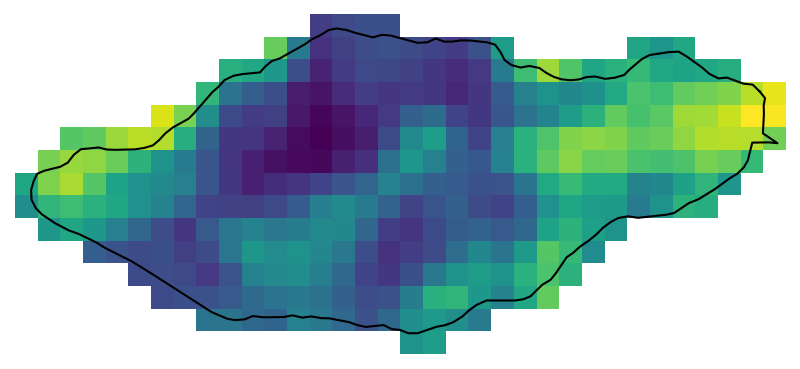

In [330]:
fig, ax = plt.subplots(dpi=150, figsize =(8, 3))

show(cropped, ax=ax)
#polygon.plot(alpha=0.25, color='white', ax=ax) # We plot both the filled in polygon
ax.plot(*polygon_geom.exterior.xy, color='k', linewidth=1) # And add a darker border

ax.set_axis_off()

### Save local file version with downloaded setting

In [ ]:
localname = 'LC08_L1TP_042034_20170616_20170629_01_T1_NDVI_OVIEW.tif'

with rasterio.open(url+nirband) as src:
    profile = src.profile.copy()

    aff = src.transform
    newaff = rasterio.Affine(aff.a * oview, aff.b, aff.c,
                             aff.d, aff.e * oview, aff.f)
    profile.update({
            'dtype': 'float32',
            'height': ndvi.shape[0],
            'width': ndvi.shape[1],
            'transform': newaff})  

    with rasterio.open(localname, 'w', **profile) as dst:
        dst.write_band(1, ndvi)

### Plot raster

https://geohackweek.github.io/raster/04-workingwithrasters/

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


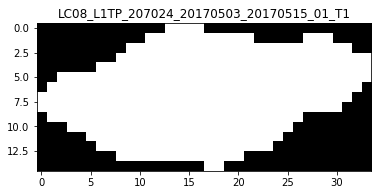

In [170]:
import matplotlib.image as mpimg

b1 = rio.open('./Landsat/Cropped/LC08_L1TP_207024_20170503_20170515_01_T1_B1.tif')
b2 = rio.open('./Landsat/Cropped/LC08_L1TP_207024_20170503_20170515_01_T1_B2.tif')
b3 = rio.open('./Landsat/Cropped/LC08_L1TP_207024_20170503_20170515_01_T1_B3.tif')

b1 = b1.read(1)
b2 = b2.read(1)
b3 = b3.read(1)

b1 = (b1 >> 8).astype('uint8')
b2 = (b2 >> 8).astype('uint8')
b3 = (b3 >> 8).astype('uint8')

rgb = np.dstack((b1,b2,b3))
    
plt.title(str(scid))
plt.imshow(rgb,vmin=25)

plt.show()

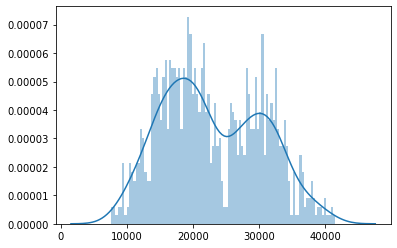

In [249]:
### 65,536 for 16-bit

import seaborn as sn

sn.distplot(rgb[rgb>0],bins=100)

### Look at netCFD xarray

In [72]:
with rio.open(filepath) as src:

    # Read the src's valid data mask as a ndarray.
    mask = src.dataset_mask()

    # Extract feature shapes and values from the array.
    for geom, val in rio.features.shapes(
            mask, transform=src.transform):

        # Transform shapes from the src's own coordinate
        # reference system to CRS84 (EPSG:4326).
        geom = rio.warp.transform_geom(
            src.crs, 'EPSG:4326', geom, precision=6)

        # Print GeoJSON shapes to stdout.
        print(geom)

{'type': 'Polygon', 'coordinates': [[[12.413911, 48.424506], [12.509558, 46.436713], [15.7321, 46.461493], [15.760251, 48.451062], [12.413911, 48.424506]]]}


In [323]:
sc_meta2 = pickle.load(open('./Landsat/Scenes/scene_'+'LE71990232012206ASN00.p',"rb"))

### Testing Google EE

root format for Top of Atmosphere (TOA) and Surface Reflectance (SR) LANDSAT/LE07/C01/T1_SR

In [497]:
import ee
ee.Initialize()

In [566]:
sc_meta2[0]['displayId']

'LE07_L1TP_199023_20120724_20161130_01_T1'

In [560]:
img =  'LANDSAT/LC08/C01/T1_SR/LC08_044034_20140318'  #'LANDSAT/LC08/C01/T1/LE71990232012206ASN00'

### Test export from EE

In [632]:
from geetools import batch
import ee


col = ee.Image(img)
export = batch.Export.image.toDrive(col,'./Landsat/Cropped/', scale=30)

#region = ee.Geometry.Polygon(polygon)
    
# dataset = ee.Image(img) #\
#     #.filterBounds(region) \
#     #.map(_mask_l8_sr)

# task = ee.batch.Export.image.toLocal(image=dataset,
#                                      description="test",
#                                      folder='./Landsat/Cropped/',
#                                      #region=region['coordinates'],
#                                      scale=30,
#                                      fileFormat='GeoTIFF',
#                                      skipEmptyTiles=False)
# task.start()


In [633]:
export

<Task EXPORT_IMAGE: ./Landsat/Cropped/ (UNSUBMITTED)>

In [585]:
import matplotlib.image as mpimg

polygon = gp.read_file("./Shapefiles/brin.shp")
polygon = polygon.to_crs(dll.crs)

filepath = './Landsat/test.tif'

src = rio.open(filepath)

polygon_reproj = polygon.to_crs(src.crs)
polygon_geom = polygon_reproj.loc[0, 'geometry']

cropped = cropper(src, polygon_geom, './Landsat/Cropped/test.TIF')


ValueError: Input shapes do not overlap raster.

In [665]:
import requests
import xmltodict

user = 'clement.attwood.18@ucl.ac.uk'
password = 'm9.iETxKMtZ6B,q'

scene = sc_meta[0]['displayId']
url = 'https://earthexplorer.usgs.gov/inventory/json/v/1.4.1/available-products/'


# r = requests.get('user':user+':'+password,url,params=PARAM)
# data = r.text

# r_dict = xmltodict.parse(r.text)#['response']['responseBody']['responseList']['item']
# df = pd.DataFrame(r_dict)
# df.head(),df.tail()

In [685]:
r = requests.get('https://espa.cr.usgs.gov/api/v0/available-products/LE07_L1TP_027027_20160730_20160831_01_T1', auth=(user, password))

---

<br>

## Using ESPA API

<br>

### Create list of scenes for download

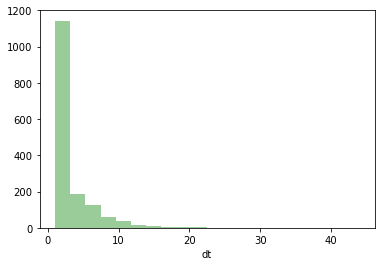

In [5]:
sites_anal = sites[(sites['l7_scene_id'].notna())|(sites['l8_scene_id'].notna())].reset_index()
temp = sites_anal.groupby('sid').count()
sn.distplot(temp.dt,kde=False,bins=20,color='g')

In [6]:
temp[temp.dt>9].head()

,dt,wb_cat,determinand_id,value,lon,lat,geometry,checked,l7_scene_n1d10c,l8_scene_n1d10c,l7_scene_id,l7_scene_dt,l8_scene_id,l8_scene_dt,l7_scene_n4d20c,l8_scene_n4d20c
sid,,,,,,,,,,,,,,,,
EL000200030020H500,13,13,13,13,13,13,13,13,13,13,11,11,9,9,9,9
EL000400030058H500,10,10,10,10,10,10,10,10,10,10,5,5,8,8,7,7
EL000400030074N500,10,10,10,10,10,10,10,10,10,10,4,4,9,9,7,7
EL000400030090N500,10,10,10,10,10,10,10,10,10,10,6,6,7,7,7,7
EL000500030040H500,10,10,10,10,10,10,10,10,10,10,5,5,6,6,8,8


In [7]:
sites_anal = sites_anal.set_index(['sid','dt'])

ziplist = zip(sites_anal.index.get_level_values(0),sites_anal.index.get_level_values(1),
              sites_anal.l7_scene_id,sites_anal.l8_scene_id)

for sid,dt,l7_scene_id,l8_scene_id in track(ziplist,len(sites)):
    
    date = dt.strftime("%Y-%m-%d")
    
    if (isinstance(l7_scene_id,str)==True):
        sc_meta7 = pickle.load(open('./Landsat/Scenes/scene_'+str(l7_scene_id)+".p","rb"))
        
        sites_anal.loc[(sid,date),'l7_display_id'] = sc_meta7[0]['displayId']
        sites_anal.loc[(sid,date),'l7_acquisition_dt'] = sc_meta7[0]['acquisitionDate']
        
        del(sc_meta7)

    elif (isinstance(l8_scene_id,str)==True):
        sc_meta8 = pickle.load(open('./Landsat/Scenes/scene_'+str(l8_scene_id)+".p","rb"))
        
        sites_anal.loc[(sid,date),'l8_display_id'] = sc_meta8[0]['displayId']
        sites_anal.loc[(sid,date),'l8_acquisition_dt'] = sc_meta8[0]['acquisitionDate']
        
        del(sc_meta8)

 [██████████████##############################################] 5231/21196 [00:26<00:00, 0.00s/it]

In [10]:
sites_anal.loc['IEMLSW_21_402_0010_S',:].head(50)

,wb_cat,determinand_id,value,lon,lat,geometry,checked,l7_scene_n1d10c,l8_scene_n1d10c,l7_scene_id,l7_scene_dt,l8_scene_id,l8_scene_dt,l7_scene_n4d20c,l8_scene_n4d20c,l7_display_id,l7_acquisition_dt,l8_display_id,l8_acquisition_dt
dt,,,,,,,,,,,,,,,,,,,
2013-07-09,LW,EEA_3164-01-0,5.2,-9.773,51.93472,POINT (-9.77300 51.93472),1,0.0,0.0,LE72080242013191EDC00,2013-07-10T11:29:09,NaN,NaN,1.0,0.0,LE07_L1TP_208024_20130710_20161123_01_T1,2013-07-10,NaN,NaN
2014-06-16,LW,EEA_3164-01-0,2.7,-9.773,51.93472,POINT (-9.77300 51.93472),1,0.0,0.0,NaN,NaN,LC82070242014163LGN01,2017-04-21T19:36:00,0.0,1.0,NaN,NaN,LC08_L1TP_207024_20140612_20170422_01_T1,2014-06-12
2014-11-12,LW,EEA_3164-01-0,2.7,-9.773,51.93472,POINT (-9.77300 51.93472),1,0.0,0.0,NaN,NaN,LC82080242014314LGN01,2017-04-17T12:54:51,0.0,1.0,NaN,NaN,LC08_L1GT_208024_20141110_20170417_01_T2,2014-11-10
2014-12-03,LW,EEA_3164-01-0,2.3,-9.773,51.93472,POINT (-9.77300 51.93472),1,0.0,0.0,NaN,NaN,LC82070242014339LGN01,2017-04-16T15:33:40,0.0,1.0,NaN,NaN,LC08_L1TP_207024_20141205_20170416_01_T1,2014-12-05
2015-03-19,LW,EEA_3164-01-0,10.0,-9.773,51.93472,POINT (-9.77300 51.93472),1,0.0,0.0,LE72070242015078NSG00,2015-03-19T11:25:42,LC82080242015077LGN01,2017-04-11T19:33:12,1.0,1.0,LE07_L1TP_207024_20150319_20161029_01_T1,2015-03-19,NaN,NaN
2015-11-19,LW,EEA_3164-01-0,2.0,-9.773,51.93472,POINT (-9.77300 51.93472),1,0.0,0.0,NaN,NaN,LC82070242015326LGN01,2017-04-01T12:18:04,0.0,1.0,NaN,NaN,LC08_L1TP_207024_20151122_20170401_01_T1,2015-11-22
2017-01-19,LW,EEA_3164-01-0,2.3,-9.773,51.93472,POINT (-9.77300 51.93472),1,1.0,0.0,LE72070242017019NSG00,2017-01-19T11:30:47,NaN,NaN,NaN,NaN,LE07_L1TP_207024_20170119_20170214_01_T1,2017-01-19,NaN,NaN
2017-05-04,LW,EEA_3164-01-0,8.6,-9.773,51.93472,POINT (-9.77300 51.93472),1,0.0,1.0,NaN,NaN,LC82070242017123LGN00,2017-05-15T15:18:19,NaN,NaN,NaN,NaN,LC08_L1TP_207024_20170503_20170515_01_T1,2017-05-03


In [115]:
dll = list(sites_anal.loc['EL000200030020H500',:].l8_display_id.unique())
dll2 = list(sites_anal.loc['EL000200030020H500',:].l7_display_id.unique())

In [116]:
[dll.append(i) for i in dll2 ]

dll = [x for x in dll if str(x) != 'nan']

### Setup API call

In [7]:
import requests
import json
import getpass

username = 'clement.attwood.18@ucl.ac.uk'
password = 'm9.iETxKMtZ6B,q'

host = 'https://espa.cr.usgs.gov/api/v1/'

## espa_api: A Function
First and foremost, define a simple function for interacting with the API. 

The key things to watch for:

* Always scrub for a `"messages"` field returned in the response, it is only informational about a request
  * **Errors** (`"errors"`): Brief exlaination about why a request failed
  * **Warnings** (`"warnings"`): Cautions about a successful response
* Always make sure the requested HTTP `status_code` returned is valid 
  * **GET**: `200 OK`: The requested resource was successfully fetched (result can still be empty)
  * **POST**: `201 Created`: The requested resource was created
  * **PUT**: `202 Accepted`: The requested resource was updated

In [5]:
def espa_api(endpoint, verb='get', body=None, uauth=None):
    """ Suggested simple way to interact with the ESPA JSON REST API """
    auth_tup = uauth if uauth else (username, password)
    response = getattr(requests, verb)(host + endpoint, auth=auth_tup, json=body)
    print('{} {}'.format(response.status_code, response.reason))
    data = response.json()
    if isinstance(data, dict):
        messages = data.pop("messages", None)  
        if messages:
            print(json.dumps(messages, indent=4))
    try:
        response.raise_for_status()
    except Exception as e:
        print(e)
        return None
    else:
        return data

In [12]:
print('GET /api/v1/user')
resp = espa_api('user')
print(json.dumps(resp))

GET /api/v1/user
200 OK
{"email": "clement.attwood.18@ucl.ac.uk", "first_name": "Clement", "last_name": "Attwood", "roles": ["active"], "username": "clement.attwood.18@ucl.ac.uk"}


### Check product availability for scene

In [119]:
scene = dll[0]

In [121]:
for scene in dll:
    avail_list = {'inputs': [scene,
                             'bad_scene_id'  # <-- Note: Unrecognized ID
                            ]
                 }
    resp = espa_api('available-products', body=avail_list)

    if 'etm7_collection' in resp.keys():  
        products = resp['etm7_collection']['products']    

    else:
        products = resp['olitirs8_collection']['products']


    sr = sum(['sr' in i for i in products])>0
    f'Surface reflectance available for scene: {sr}'

    print(products)

200 OK
['source_metadata', 'l1', 'toa', 'bt', 'sr', 'sr_ndvi', 'sr_evi', 'sr_savi', 'sr_msavi', 'sr_ndmi', 'sr_nbr', 'sr_nbr2', 'stats', 'pixel_qa']


### Create an order

In [130]:
#if sr==True:

# Differing products across the sensors
l_prods = ['sr']

# # Standard Albers CONUS
projection = {'aea': {'standard_parallel_1': 29.5,
                      'standard_parallel_2': 45.5,
                      'central_meridian': -96.0,
                      'latitude_of_origin': 23.0,
                      'false_easting': 0,
                      'false_northing': 0,
                      'datum': 'nad83'}}

# Let available-products place the acquisitions under their respective sensors
ls = dll

order = espa_api('available-products', body=dict(inputs=ls))
print(json.dumps(order['inputs']))

GET /api/v1/available-products
200 OK
{
    "olitirs8_collection": {
        "products": [
            "source_metadata",
            "l1",
            "toa",
            "bt",
            "sr",
            "sr_ndvi",
            "sr_evi",
            "sr_savi",
            "sr_msavi",
            "sr_ndmi",
            "sr_nbr",
            "sr_nbr2",
            "stats",
            "pixel_qa"
        ],
        "inputs": [
            "LC08_L1TP_184033_20130726_20180527_01_T1",
            "LC08_L1TP_184033_20150614_20170408_01_T1"
        ]
    },
    "etm7_collection": {
        "products": [
            "source_metadata",
            "l1",
            "toa",
            "bt",
            "sr",
            "sr_ndvi",
            "sr_evi",
            "sr_savi",
            "sr_msavi",
            "sr_ndmi",
            "sr_nbr",
            "sr_nbr2",
            "stats",
            "pixel_qa"
        ],
        "inputs": [
            "LE07_L1TP_183034_20130609_20161124_01_T1",


In [131]:
# Replace the available products that was returned with what we want
for sensor in order.keys():
    if isinstance(order[sensor], dict) and order[sensor].get('inputs'):
        if set(ls) & set(order[sensor]['inputs']):
            order[sensor]['products'] = l_prods

# Add in the rest of the order information
order['projection'] = projection
order['format'] = 'gtiff'
order['resampling_method'] = 'cc'
order['note'] = 'API Demo Jupyter!!'

# Notice how it has changed from the original call available-products
print(json.dumps(order, indent=4))

{
    "olitirs8_collection": {
        "products": [
            "sr"
        ],
        "inputs": [
            "LC08_L1TP_184033_20130726_20180527_01_T1",
            "LC08_L1TP_184033_20150614_20170408_01_T1"
        ]
    },
    "etm7_collection": {
        "products": [
            "sr"
        ],
        "inputs": [
            "LE07_L1TP_183034_20130609_20161124_01_T1",
            "LE07_L1TP_184033_20130819_20161122_01_T1",
            "LE07_L1TP_183034_20130929_20161120_01_T1",
            "LE07_L1TP_183034_20140511_20161115_01_T1",
            "LE07_L1TP_184034_20140619_20161113_01_T1",
            "LE07_L1TP_183034_20140714_20161112_01_T1",
            "LE07_L1TP_184034_20140822_20161113_01_T1",
            "LE07_L1TP_183034_20140831_20161112_01_T1",
            "LE07_L1TP_184033_20150724_20161023_01_T1",
            "LE07_L1TP_183034_20150818_20161021_01_T1",
            "LE07_L1TP_183034_20150919_20161019_01_T1"
        ]
    },
    "projection": {
        "aea": {
       

### Place the order

In [135]:
resp = espa_api('order', verb='post', body=order)
orderid = resp["orderid"]
print(json.dumps(resp, indent=4))

201 CREATED
{
    "orderid": "espa-clement.attwood.18@ucl.ac.uk-02282020-104208-641",
    "status": "ordered"
}


### Check order status and retrieve download link

In [139]:
dl = espa_api('item-status/{0}'.format(orderid), body={'status': 'complete'})

200 OK


In [150]:
while resp['status']=='ordered':
    
    resp = espa_api('order-status/{}'.format(orderid))
    
    time.sleep(30)
    
    if resp['status']=='complete':
        
        print('FINISHED')
        
        ### get order details
        dl = espa_api('item-status/{0}'.format(orderid), body={'status': 'complete'})
    
        ### create list of links
        dllink = []
        dllink += [ item.get('product_dload_url') for item in dl[orderid] ]
        
        for link in dllink:
            
            ### check if downloaded already
            tardl = urllib.request.urlopen(dllink[1])
            tar = tarfile.open(fileobj=tardl, mode="r:gz")
            tar.extractall()

        break



200 OK
ordered
200 OK
ordered
200 OK
ordered
200 OK
ordered
200 OK
ordered
200 OK
ordered
200 OK
complete
FINISHED
200 OK
